## Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from matplotlib import pyplot as plt
sns.set(style="white")

%matplotlib inline

def heatmap(data, *cols, target, xtick=None, ytick=None, annot=True, fmt='.2f', figsize=None):
    import seaborn as sns
    from matplotlib import pyplot as plt

    figsize = figsize or (16, 4)
    f, axs = plt.subplots(1, 2, figsize=figsize)

    def draw(chop, axis):
        pivot_params = list(cols) + [target]
        g = chop.groupby(list(cols))[target]
        mean_ = g.mean().reset_index().pivot(*pivot_params)
        count_ = g.size().reset_index().pivot(*pivot_params)
        if xtick is not None or ytick is not None:
            mean_ = mean_.reindex(index=ytick, columns=xtick)
            count_ = count_.reindex(index=ytick, columns=xtick)

        sns.heatmap(mean_.fillna(0), annot=annot, ax=axis[0], fmt=fmt, cmap="YlGnBu")
        sns.heatmap(count_.fillna(0), annot=annot, ax=axis[1], fmt=fmt, cmap="YlGnBu")
        axis[0].set_title('mean')
        axis[1].set_title('count')

    draw(data, axs)
    plt.show()
    
    
def chi_square(x, y, data, verbose=True):
    """
    Return: True if x is dependet with y else False
    """
    table = data.groupby([x, y]).size().reset_index(name='size')
    pivot = table.pivot(index=x, columns=y, values='size').fillna(0.)
    
    # Calculate chi-square value, p-value, degree of freedom, expected value
    chi, pv, df, expected = stats.chi2_contingency(observed=pivot.values)
    # check if chi-square value > criterion(95% confidence interval)
    crit = stats.chi2.ppf(q=0.95, df=df)
    if verbose:
        print(pivot)
        print()
        print(expected)
        print()
        print(f'chi-square value: {chi}, criterion: {crit}')
    return chi > crit

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


# Purpose: 
* 給定電信客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?


## Data Schema

Column name         | Description
				 ---|---
customerIDCustomer 	|	ID
genderCustomer  	|	gender (female, male)
SeniorCitizen    	|	Whether the customer is a senior citizen or not (1, 0)
Partner    			|	Whether the customer has a partner or not (Yes, No)
Dependents    		|	Whether the customer has dependents or not (Yes, No)
tenure				|	Number of months the customer has stayed with the company
PhoneService    	|	Whether the customer has a phone service or not (Yes, No)
MultipleLines    	|	Whether the customer has multiple lines or not (Yes, No, No phone service)
InternetService		|	Customer’s internet service provider (DSL, Fiber optic, No)
OnlineSecurity    	|	Whether the customer has online security or not (Yes, No, No internet service)
OnlineBackup    	|	Whether the customer has online backup or not (Yes, No, No internet service)
DeviceProtection   	|	Whether the customer has device protection or not (Yes, No, No internet service)
TechSupport    		|	Whether the customer has tech support or not (Yes, No, No internet service)
StreamingTV    		|	Whether the customer has streaming TV or not (Yes, No, No internet service)
StreamingMovies    	|	Whether the customer has streaming movies or not (Yes, No, No internet service)
contract 			|	The contract term of the customer (Month-to-month, One year, Two year)
PaperlessBilling    |	Whether the customer has paperless billing or not (Yes, No)
PaymentMethod		|	The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges		|	The amount charged to the customer monthly
TotalCharges		|	The total amount charged to the customer
churned				|	Whether the customer churned or not (Yes or No)

---

* 16個類別變數(customer id 不算)
* 3個numeric變數 (當中`tenure`也可算是Ordinal變數)


---
<br/>
<br/>
<br/>

# EDA(Exploratory Data Analysis)


---



In [2]:
raw_telco = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_telco_customer_churn.csv")

# transform [Yes No] to [1, 0]
raw_telco['Churn'] = raw_telco.Churn.map(lambda e: 1 if e == 'Yes' else 0)
raw_telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [4]:
raw_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
customerID          5634 non-null object
gender              5634 non-null object
SeniorCitizen       5634 non-null int64
Partner             5634 non-null object
Dependents          5634 non-null object
tenure              5634 non-null int64
PhoneService        5634 non-null object
MultipleLines       5634 non-null object
InternetService     5634 non-null object
OnlineSecurity      5634 non-null object
OnlineBackup        5634 non-null object
DeviceProtection    5634 non-null object
TechSupport         5634 non-null object
StreamingTV         5634 non-null object
StreamingMovies     5634 non-null object
Contract            5634 non-null object
PaperlessBilling    5634 non-null object
PaymentMethod       5634 non-null object
MonthlyCharges      5634 non-null float64
TotalCharges        5634 non-null object
Churn               5634 non-null int64
dtypes: float64(1), int64(3), obje

## Data Clean: TotalCharges

* 讀取進來的時候因為有空字串, 導致於變成字串type, 需要轉型為float, 並且做missing value imputing

In [0]:
# TotalCharges 讀取進來的時候因為有missing value, 導致於變成字串type, 需要轉型為float, 並且做missing value imputing
def str2num(e):
    try:
        return float(e)
    except:
        return np.nan
              
tmp = raw_telco.TotalCharges.map(str2num)
raw_telco['TotalCharges'] = tmp.fillna(tmp.median())
del tmp

## Observe the label distribution

0    4124
1    1510
Name: Churn, dtype: int64



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  cat_pos = np.ones(swarm_data.size) * center


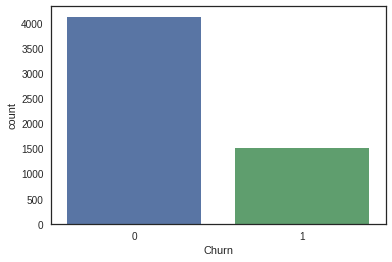

In [8]:
print( raw_telco.Churn.value_counts() )
print()
raw_telco.Churn.describe()
sns.countplot(x='Churn', data=raw_telco)

## Observation

* Not Churn : Churn 的數量大約是 1 : 3 左右

---

<br/>
<br/>
<br/>

# 多變數分析: Categorical x Categorical

* heatmap: 也可個別觀察單變數與Label之間的關係
---



## 類別變數的 Correlation Heatmap

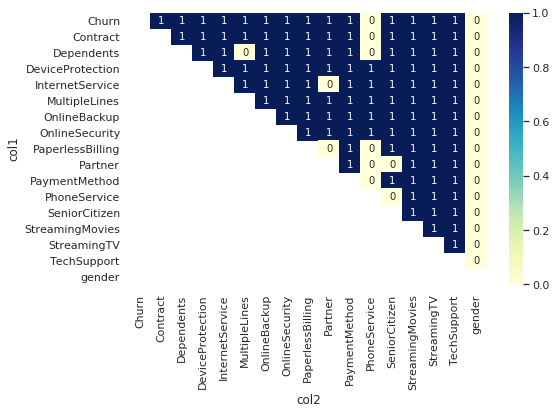

In [31]:
catg_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PhoneService', 'MultipleLines', 'InternetService',
        'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']


def catg_corr(catg_cols, data):
    corr = []
    for i, x in enumerate(catg_cols):
        corr += [(x, x, 1)]
        for y in catg_cols[i+1:]:
            r = int(chi_square(x, y, data, verbose=False))
            corr += [(x, y, r), (y, x, r)]
            
    corr = pd.DataFrame(data=corr, columns=['col1', 'col2', 'val'])\
             .pivot('col1', 'col2', 'val')
    return corr

corr = catg_corr(catg_features, raw_telco)
plt.figure(figsize=(8, 5))
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(corr, cmap="YlGnBu", mask=mask, annot=True)

## Contract x Gender: Heatmap

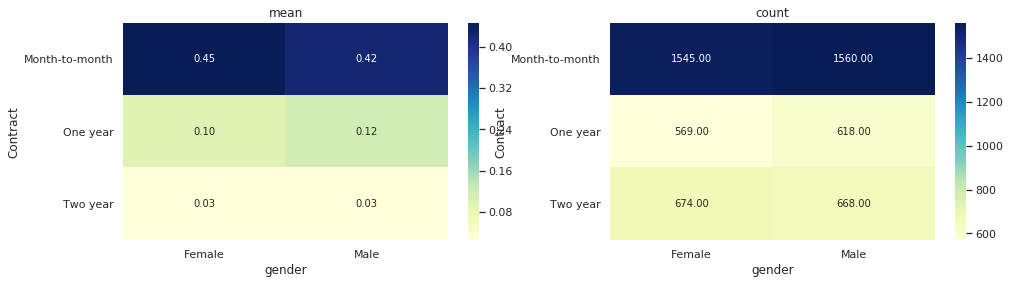

In [7]:
heatmap(raw_telco, 'Contract', 'gender', target='Churn')

## Contract x SeniorCitizen: Heatmap


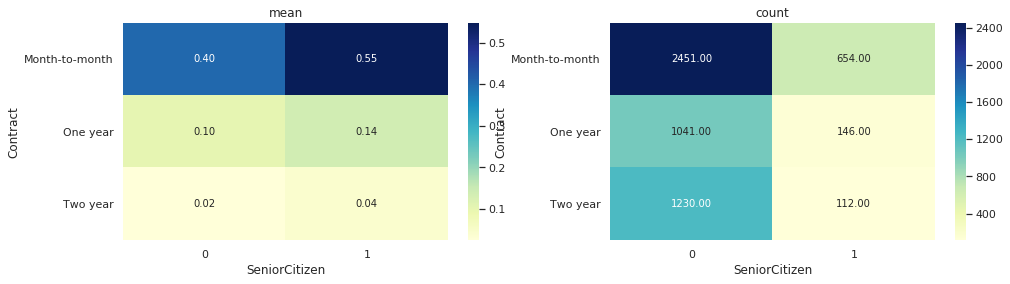

In [8]:
heatmap(raw_telco, 'Contract', 'SeniorCitizen', target='Churn')

## (LAB) Contract x PaymentMethod: Heatmap

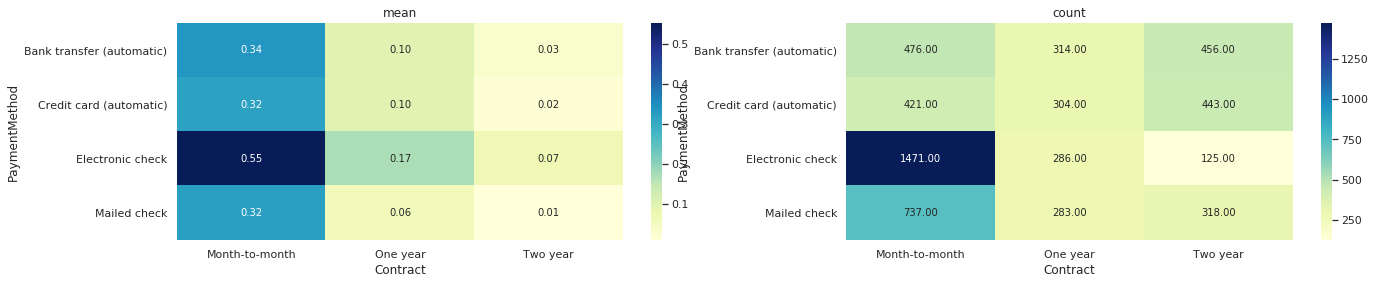

In [17]:
heatmap(raw_telco, 'PaymentMethod', 'Contract', target='Churn', figsize=(22, 4))

## (LAB) Partner x Dependents(有無伴侶, 是否有家屬): Heatmap

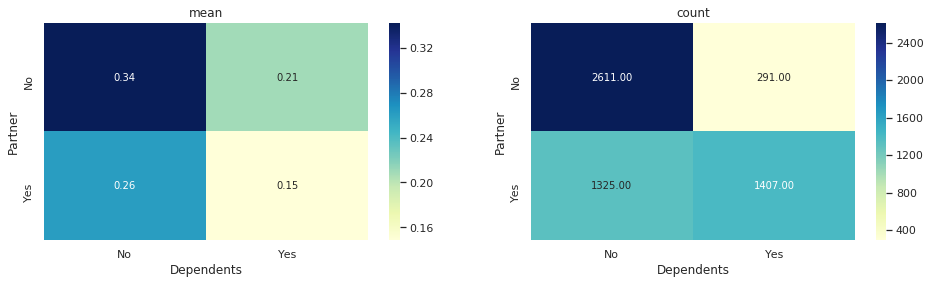

In [18]:
heatmap(raw_telco, 'Partner', 'Dependents', target='Churn')

## (LAB) PhoneService x InternetService: Heatmap

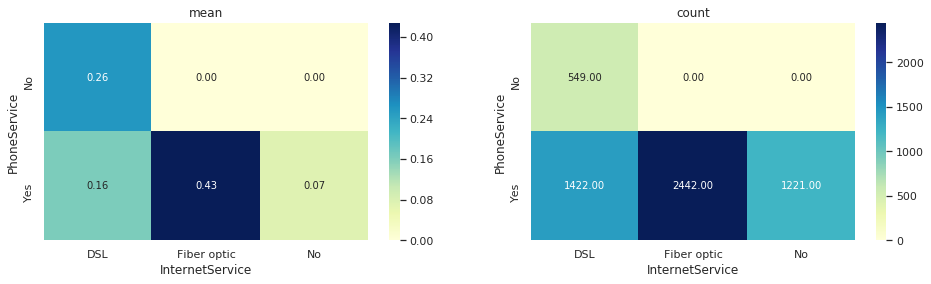

In [30]:
heatmap(raw_telco, 'PhoneService', 'InternetService', target='Churn')

## OnlineSecurity x OnlineBackup x DeviceProtection x TechSupport x StreamingTV x StreamingMovies

* 額外加值服務欄位都隸屬於 `InternetService`
* `InternetService` =  `No` 代表這6個欄位都一定是 **No internet service**

In [73]:
raw_telco.query("InternetService != 'No'")[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,DSL,No,Yes,No,No,No,No
1,DSL,Yes,No,Yes,No,No,No
2,DSL,Yes,Yes,No,No,No,No
3,DSL,Yes,No,Yes,Yes,No,No
4,Fiber optic,No,No,No,No,No,No


In [0]:
# cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
# tmp = raw_telco.query("InternetService != 'No'")
# tmp = pd.melt(tmp[cols]).rename({'value': 'service'}, axis=1)
# tmp.head(10)

In [0]:
# cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# tmp = raw_telco.query("InternetService != 'No'")
# tmp = pd.melt(tmp[cols]).rename({'value': 'service'}, axis=1)
# plt.figure(figsize=(10, 4))
# sns.countplot(x='variable', hue='service', data=tmp, hue_order=['No', 'Yes'])
# plt.title('Total Count')

# tmp = raw_telco.query("InternetService != 'No' and Churn == 1")
# tmp = pd.melt(tmp[cols]).rename({'value': 'service'}, axis=1)
# plt.figure(figsize=(10, 4))
# sns.countplot(x='variable', hue='service', data=tmp, hue_order=['No', 'Yes'])
# plt.title('Churn Count')

# * `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, 4種額外internet service用戶似乎有比較低的Churn rate

## Observation

* `SeniorCitizen` 是顯著Feature
* `Partner` 是顯著Feature
* `Dependent` 是顯著Feature  
* `PaymentMethod` 是顯著Feature
* `PhoneService` 是顯著Feature, `PhoneService = No` 人數非常少
* `InternetService` 是顯著Feature,  `InternetService= Fiber optic` and `PhoneService = Yes` 有顯著退租風險


<br/>
<br/>
<br/>

---

# 多變數分析: Categorical x Numeric


## Contract x Tenure: Violin Plot, Distribution Plot

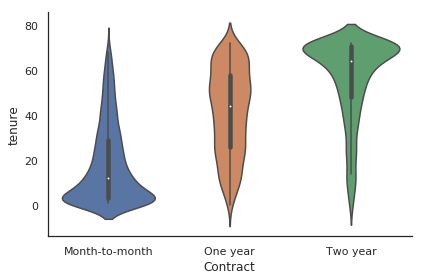

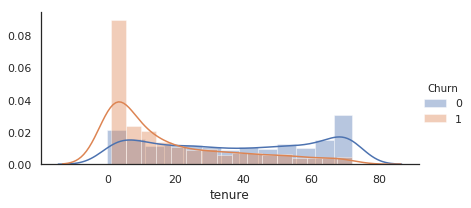

In [101]:
ax = sns.catplot(data=raw_telco,
            x='Contract',
            y='tenure',
            # hue='Churn',
            split=True,
            kind='violin', height=4, aspect=1.5)
plt.show()

g = sns.FacetGrid(hue='Churn',
                  data=raw_telco,
                  aspect=2)
g.map(sns.distplot, 'tenure').add_legend()

## Contract x MonthlyCharges: Violin Plot, Distribution Plot

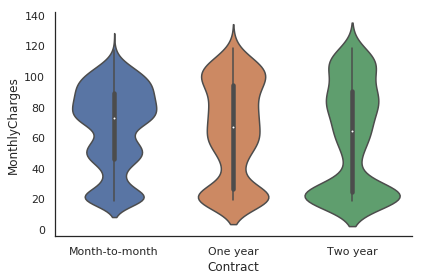

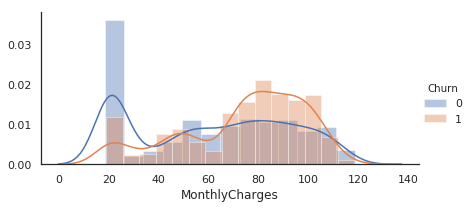

In [104]:
ax = sns.catplot(data=raw_telco,
                x='Contract',
                y='MonthlyCharges',
                # hue='Churn',
                split=True,
                kind='violin', height=4, aspect=1.5)
plt.show()

g = sns.FacetGrid(hue='Churn',
                  data=raw_telco, 
                  aspect=2)
g.map(sns.distplot, 'MonthlyCharges').add_legend()

## PaymentMethod x MonthlyCharges: Violin Plot

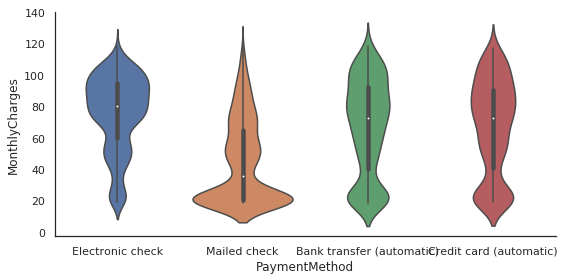

In [107]:
ax = sns.catplot(data=raw_telco,
                x='PaymentMethod',
                y='MonthlyCharges',
                # hue='Churn',
                split=True,
                kind='violin', height=4, aspect=2)
plt.show()

## (LAB) PaymentMethod x TotalCharges: Violin Plot

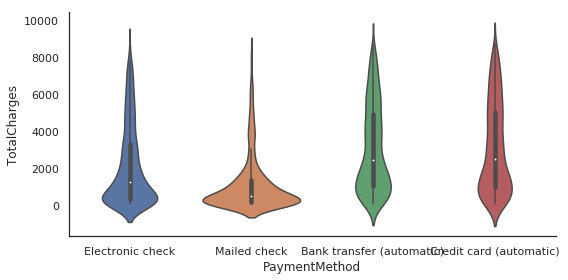

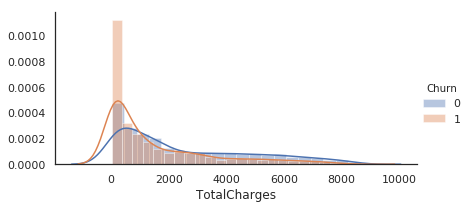

In [110]:
ax = sns.catplot(data=raw_telco,
                x='PaymentMethod',
                y='TotalCharges',
                # hue='Churn',
                split=True,
                kind='violin', height=4, aspect=2)
plt.show()

g = sns.FacetGrid(hue='Churn',
                  data=raw_telco, 
                  aspect=2)
g.map(sns.distplot, 'TotalCharges').add_legend()

## (LAB) MonthlyCharges x InternetService: Violin Plot

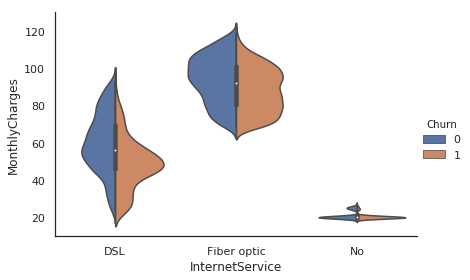

In [52]:
_ = sns.catplot(data=raw_telco,
                x='InternetService', 
                y='MonthlyCharges',
                hue='Churn',
                kind='violin', 
                split=True,
                height=4, aspect=1.5)
plt.show()

## Observation

* 合約在一年以上的, 退租的人大多是月繳比較高的 (High MonthlyCharges)

---

* 相關性:
    - `Contract`,  `Tenure` 有非線性關係
    - `InternetService`,  `MonthlyCharges` 有非線性關係
    - `PaymentMethod`,  `MonthlyCharges` 有非線性關係
    - `PaymentMethod`,  `TotalCharges` 有非線性關係

* 顯著:
    - `PaymentMethod`
    - `MonthlyCharges`
    -  `Tenure`





---


# 多變數分析: Numeric x Numeric

## Correlation: Pearson, Spearman
- Pearson: 變數最好遵從常態分配, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})} {\sqrt{\sum(x_i - \bar{x})^2(y_i - \bar{y})^2}} $$

---

- Spearman: 只注重排序關係, numeric, ordinal變數都可以接受, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = 1 - \frac{6  \sum d_i^2} {n(n^2 - 1)} $$

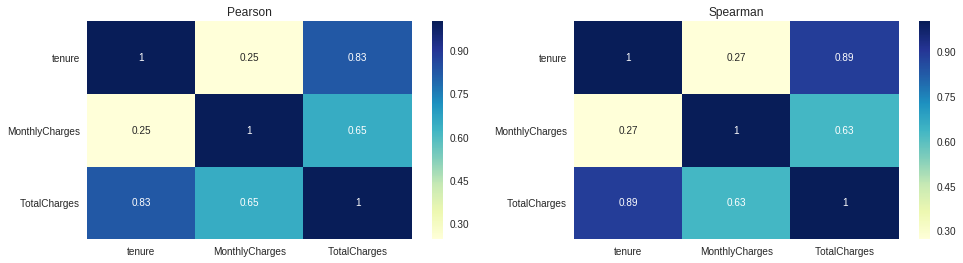

In [0]:
f, axis = plt.subplots(1, 2, figsize=(16, 4))

tmp = raw_telco[['tenure', 'MonthlyCharges', 'TotalCharges']]
sns.heatmap(tmp.corr(), annot=True, cmap='YlGnBu', ax=axis[0])
sns.heatmap(tmp.corr(method='spearman'), annot=True, cmap='YlGnBu', ax=axis[1])
axis[0].set_title('Pearson')
axis[1].set_title('Spearman')
plt.show()

##  TotalCharges x tenure: Regression Plot

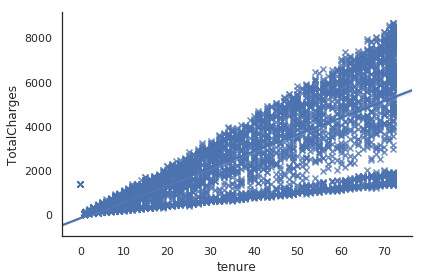

In [4]:
g = sns.lmplot(x='tenure', y='TotalCharges',
               data=raw_telco, height=4, aspect=1.5, markers='x')

##  MonthlyCharges x tenure: Regression Plot

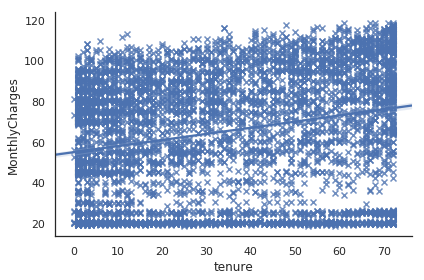

In [5]:
g = sns.lmplot(x='tenure', y='MonthlyCharges',
               data=raw_telco, height=4, aspect=1.5, markers='x')

## MonthlyCharges x TotalCharges: Regression Plot

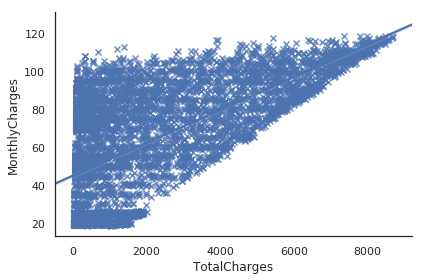

In [6]:
g = sns.lmplot(x='TotalCharges', y='MonthlyCharges',
               data=raw_telco, height=4, aspect=1.5, markers='x')

### 觀察一下為什麼`Tenure` `TotalCharges` `MonthlyCharges`有高度線性正向關係

In [0]:
raw_telco[['MonthlyCharges', 'tenure', 'TotalCharges']].head()

,MonthlyCharges,tenure,TotalCharges
0,29.85,1,29.85
1,56.95,34,1889.50
2,53.85,2,108.15
3,42.30,45,1840.75
4,70.70,2,151.65


### Observation

* `TotalCharges` 近似於  `MonthlyCharges` * `Tenure` 
* **理當來說應該是要完全一致的數字, 但是卻有偏差, 有可能是資料float差異, 或是其它因素**


### 新增`charges_diff`欄位

In [8]:
raw_telco['charges_diff'] = np.abs(raw_telco.MonthlyCharges * raw_telco.tenure - raw_telco.TotalCharges)
raw_telco[['MonthlyCharges', 'tenure', 'TotalCharges', 'charges_diff']].head()

,MonthlyCharges,tenure,TotalCharges,charges_diff
0,29.85,1,29.85,0.00
1,56.95,34,1889.50,46.80
2,53.85,2,108.15,0.45
3,42.30,45,1840.75,62.75
4,70.70,2,151.65,10.25


count    5634.000000
mean       47.236812
std        75.316467
min         0.000000
25%         9.300000
50%        28.550000
75%        63.237500
max      1385.300000
Name: charges_diff, dtype: float64


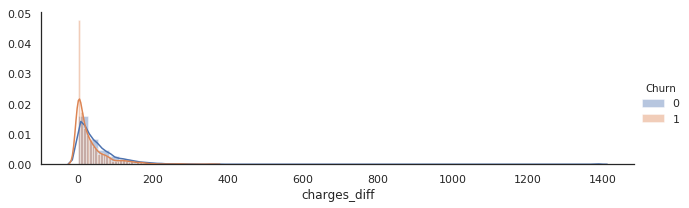

In [29]:
print( raw_telco.charges_diff.describe() )
g = sns.FacetGrid(data=raw_telco, hue='Churn', height=3, aspect=3)
g.map(sns.distplot, 'charges_diff').add_legend()

# sns.catplot(x='Churn', y='charges_diff', data=raw_telco, kind='violin')
# plt.show()

## Observation

* 新增的欄位 `charges_diff` 對於Churn並沒有顯著不同的分布


---

<br/>
<br/>
<br/>

# Conclusion

* 顯著變數
    - Numeric
        - tenure
        - MonthlyCharges

    - Categorical
        - SeniorCitizen
        - Contract
        - PaymentMethod
        - PaperlessBilling
        - Partner
        - Dependents
        - MultipleLines
        - OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, InternetService
        
        
* 變數相關性
    - `tenure, MonthlyCharges` 與 `TotalCharges` 正相關
    - `InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies` 非線性相關
    - 其餘參考 Chi Square Correlation Table, 和 Pearson Correlation Table

In [0]:
# catg_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
#        'PhoneService', 'MultipleLines', 'InternetService',
#        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
#        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
#        'PaymentMethod', 'Churn']

# num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# tmp = raw_telco.drop(['customerID'], 1)
# corr = tmp.apply(lambda x: x if x.name in num_features else pd.factorize(x)[0]).corr()

# plt.figure(figsize=(12, 6))
# ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
#                  linewidths=.2, cmap="YlGnBu")